In [1]:
import sys
sys.path.append(r"/mnt/ceph/users/tudomlumleart/00_VirtualEnvironments/teeu/lib/python3.10/site-packages")
sys.path.append(r"/mnt/home/tudomlumleart/.local/lib/python3.10/site-packages/")
sys.path.append(r"/mnt/home/tudomlumleart/ceph/00_VirtualEnvironments/jupyter-gpu/lib/python3.10/site-packages")
from utils import *
from functions import *
from sklearn.mixture import BayesianGaussianMixture
import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import validation_curve

from sklearn.metrics import adjusted_mutual_info_score

import os
import scipy.io

# Use Low Rank completion from pylop and pyproximal 
import pylops
import pyproximal 

2024-07-23 11:11:53.699803: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/cupy/_environment.py:438: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy, cupy-cuda11x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate 

In [2]:
# Load the data from the dataset 
dataset_dir = '/mnt/home/tudomlumleart/ceph/03_GaussianChainSimulation/20240627/dataset_100_10_20_10_1000_40.0_10000.pkl'

dataset_list, param_dict = load_dataset(dataset_dir)

template_list = dataset_list[0]['template_chain_list']
X = dataset_list[0]['observation_list']
label_list = dataset_list[0]['labels']

observations_flatten = [squareform(pdist(x)).flatten() for x in X]

# generate weight of each label from label_list
true_weights = np.array([np.sum(label_list == i) for i in np.unique(label_list)]) / len(label_list)
templates_flatten = [squareform(pdist(x)).flatten() for x in template_list]

# Generate random walk for guessing structures
num_monomers = param_dict['num_monomers']
mean_bond_length = param_dict['mean_bond_length']
std_bond_length = param_dict['std_bond_length'] 
num_templates = param_dict['num_templates']
measurement_error = param_dict['noise_std']
num_observations = param_dict['num_observations']
num_probes = num_monomers
num_candidates = num_templates

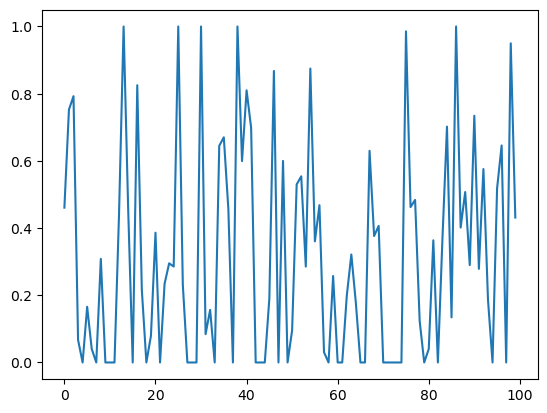

In [3]:
# Introducing missing data to the dataset at specific barcodes with some probabiliity between [0, 1]
missing_data_prob = np.random.normal(0.1, 0.5, num_monomers)
missing_data_prob[missing_data_prob < 0] = 0
missing_data_prob[missing_data_prob > 1] = 1
plt.plot(missing_data_prob)

# Get shuffle indices for shuffling dataset 
shuffle_indices = np.arange(num_observations)
np.random.shuffle(shuffle_indices)

observations_with_nan = np.array([squareform(pdist(x)) for x in X])
observations_with_nan = observations_with_nan[shuffle_indices, :, :]
existing_data = np.zeros(observations_with_nan.shape)
# Randomly add nan to the dataset based on the missing_data_prob
for i in range(num_observations):
    missing_indices = np.random.uniform(size=num_monomers) < missing_data_prob
    observations_with_nan[i, missing_indices, :] = 0
    observations_with_nan[i, :, missing_indices] = 0
    existing_data[i, ~missing_indices, :] = 1
    existing_data[i, :, ~missing_indices] = 1
    
existing_data_flatten = np.array([x.flatten() for x in existing_data.astype(bool)])
observations_flatten = np.array([squareform(pdist(x)) for x in X])[shuffle_indices, :, :]
observations_flatten = np.array([x.flatten() for x in observations_flatten])
observations_flatten_with_nan = np.array([x.flatten() for x in observations_with_nan])

In [5]:
def nuclear_norm_projection(matrix, rank):
    """
    Projects the given matrix to the set of matrices with nuclear norm <= rank
    """
    U, S, Vt = np.linalg.svd(matrix, full_matrices=False)
    S[rank:] = 0
    return U @ np.diag(S) @ Vt

def compute_gradient(X, observed_indices, observed_values):
    """
    Computes the gradient of the objective function with respect to the observed entries.
    """
    gradient = np.zeros_like(X)
    for (i, j), value in zip(observed_indices, observed_values):
        gradient[i, j] = 2 * (X[i, j] - value)
    return gradient

def frank_wolfe_low_rank_completion(observed_indices, observed_values, shape, rank, num_iterations=100, tol=1e-5):
    """
    Frank-Wolfe algorithm for low-rank matrix completion.

    Parameters:
    observed_indices: list of tuples (i, j) indicating the positions of observed entries
    observed_values: list of observed values corresponding to observed_indices
    shape: tuple indicating the shape of the matrix (n_rows, n_cols)
    rank: desired rank of the completed matrix
    num_iterations: maximum number of iterations
    tol: tolerance for convergence

    Returns:
    X: completed matrix
    """
    X = np.zeros(shape)  # Initial guess
    for iteration in range(num_iterations):
        gradient = compute_gradient(X, observed_indices, observed_values)
        U, s, Vt = np.linalg.svd(-gradient, full_matrices=False)
        S = np.zeros_like(X)
        S[:U.shape[1], :Vt.shape[0]] = np.outer(U[:, 0], Vt[0, :])

        # Line search to find optimal step size
        step_size = 2 / (iteration + 2)
        X_new = (1 - step_size) * X + step_size * S

        # Projection onto the set of low-rank matrices
        X_new = nuclear_norm_projection(X_new, rank)

        # Check for convergence
        if np.linalg.norm(X_new - X) < tol:
            break

        X = X_new
        print(f"Iteration {iteration + 1}: Frobenius norm of the difference: {np.linalg.norm(X_new - X)}")

    return X

In [23]:
# Example usage
observed_indices = [(0, 0), (0, 1), (1, 0), (1, 1)]
observed_values = [1, 2, 3, 4]
shape = (4, 4)
rank = 1
completed_matrix = frank_wolfe_low_rank_completion(observed_indices, observed_values, shape, rank)
print("Completed matrix:")
print(completed_matrix)

Iteration 1: Frobenius norm of the difference: 0.0
Completed matrix:
[[0.23304246 0.3306884  0.         0.        ]
 [0.52680453 0.74753822 0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]


In [ ]:
# Example usage
observed_indices = [(0, 0), (0, 1), (1, 0), (1, 1)]
observed_values = [1, 2, 3, 4]
shape = (4, 3)
rank = 1
completed_matrix = frank_wolfe_low_rank_completion(observed_indices, observed_values, shape, rank)
print("Completed matrix:")
print(completed_matrix)

In [24]:
barcode_id = 0
map_nan = observations_flatten_with_nan[:100, num_probes*barcode_id:num_probes*(barcode_id+1)]
map = observations_flatten[:100, num_probes*barcode_id:num_probes*(barcode_id+1)]
existing_indices = existing_data_flatten[:100, num_probes*barcode_id:num_probes*(barcode_id+1)]

In [19]:
np.argwhere(existing_indices).tolist()

[[0, 0],
 [0, 1],
 [0, 2],
 [0, 3],
 [0, 4],
 [0, 5],
 [0, 6],
 [0, 7],
 [0, 8],
 [0, 9],
 [0, 10],
 [0, 11],
 [0, 12],
 [0, 13],
 [0, 14],
 [0, 15],
 [0, 16],
 [0, 17],
 [0, 18],
 [0, 19],
 [0, 20],
 [0, 21],
 [0, 22],
 [0, 23],
 [0, 24],
 [0, 25],
 [0, 26],
 [0, 27],
 [0, 28],
 [0, 29],
 [0, 30],
 [0, 31],
 [0, 32],
 [0, 33],
 [0, 34],
 [0, 35],
 [0, 36],
 [0, 37],
 [0, 38],
 [0, 39],
 [0, 40],
 [0, 41],
 [0, 42],
 [0, 43],
 [0, 44],
 [0, 45],
 [0, 46],
 [0, 47],
 [0, 48],
 [0, 49],
 [0, 50],
 [0, 51],
 [0, 52],
 [0, 53],
 [0, 54],
 [0, 55],
 [0, 56],
 [0, 57],
 [0, 58],
 [0, 59],
 [0, 60],
 [0, 61],
 [0, 62],
 [0, 63],
 [0, 64],
 [0, 65],
 [0, 66],
 [0, 67],
 [0, 68],
 [0, 69],
 [0, 70],
 [0, 71],
 [0, 72],
 [0, 73],
 [0, 74],
 [0, 75],
 [0, 76],
 [0, 77],
 [0, 78],
 [0, 79],
 [0, 80],
 [0, 81],
 [0, 82],
 [0, 83],
 [0, 84],
 [0, 85],
 [0, 86],
 [0, 87],
 [0, 88],
 [0, 89],
 [0, 90],
 [0, 91],
 [0, 92],
 [0, 93],
 [0, 94],
 [0, 95],
 [0, 96],
 [0, 97],
 [0, 98],
 [0, 99],
 [1, 3],
 

In [27]:
frank_wolfe_low_rank_completion(np.argwhere(existing_indices).tolist(), (map_nan[existing_indices]).ravel(), map_nan.shape, 50)

Iteration 1: Frobenius norm of the difference: 0.0


array([[-1.25180095e-17,  4.76061531e-04,  4.68270664e-04, ...,
         2.83864536e-02,  2.09568440e-03,  1.51380602e-02],
       [-1.10933565e-32,  4.21881797e-19,  4.14977589e-19, ...,
         2.51558405e-17,  1.85717818e-18,  1.34152238e-17],
       [-6.93334780e-34,  2.63676141e-20,  2.59360985e-20, ...,
         1.57224003e-18,  1.16073635e-19,  8.38451486e-19],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])